<a href="https://colab.research.google.com/github/nasrinsaalehi/Drawning-Detection-/blob/main/01_My_Pytorch_Workflow_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
import torch
import matplotlib.pyplot as plt
from torch import nn 


Lets make the data using linear regression

In [68]:
weight= 0.7
bias= 0.3

X= torch.arange(start=0, end=1, step=0.02).unsqueeze(dim=1)
y= weight * X+ bias

Lets Creat a Training and test set with our data


In [69]:
# Creat a train and test split
train_split = int(0.8* len(X))
X_train, y_train= X[:train_split], y[:train_split]
X_test, y_test= X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [104]:
def plt_predictions(train_data= X_train,
                    train_labels= y_train,
                    test_data= X_test,
                    test_labels= y_test,
                    predictions= None):
  """
  Plots training data, test data and compares predictions if available
  """
  plt.figure(figsize= (10,7))

  #plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s= 4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label= "Test data")

  # Are there any predictions?
  if predictions is not None:
    # Plot the predictions of they exist 
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend: shows the labels on the plot
  plt.legend(prop= {"size":14});

### 2. Build the model

In [71]:
from torch import nn

# Create linear regression model class
class LinearRegressionModel(nn.Module):
  # almost everything in pytorch inherrits from nn.module class
  def __init__(self):
    super().__init__()
    self.weight= nn.Parameter(torch.randn(1,
                                        requires_grad=True,
                                        dtype= torch.float))
    self.bias= nn.Parameter(torch.randn(1,
                                        requires_grad= True,
                                        dtype= torch.float))
    
  #Forward method to defining the computaion in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # "x" is the input data that is expected to be a torch.Tensor
    # the model outputs a torch.Tensor
    return self.weight * x + self.bias

In [72]:
# Create an instant of our model (a subclass of nn.Module)
model_0= LinearRegressionModel()

# chech the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.2345], requires_grad=True), Parameter containing:
 tensor([0.2303], requires_grad=True)]

In [73]:
# List named parameters
model_0.state_dict()

OrderedDict([('weight', tensor([0.2345])), ('bias', tensor([0.2303]))])

In [74]:
X_test, y_test

(tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]), tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

# Making prediction using `torch.inference_mode()`

To check our model's predictive power, lets see how well predics `y_test` based on `X_test`.
when we pass data through our model, its going to run it through the `forward()` method


In [75]:
# Make predictions with model
with torch.inference_mode():
  y_preds= model_0(X_test)
y_preds

tensor([[0.4179],
        [0.4226],
        [0.4273],
        [0.4320],
        [0.4367],
        [0.4413],
        [0.4460],
        [0.4507],
        [0.4554],
        [0.4601]])

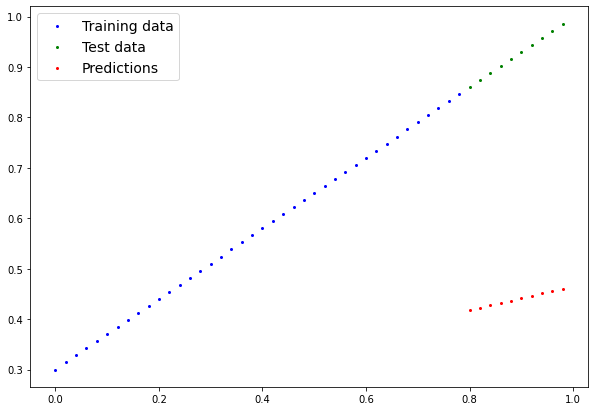

In [76]:
plt_predictions(predictions= y_preds)

In [77]:
with torch.no_grad():
  y_preds_same_as_inference_mode= model_0(X_test)

y_preds_same_as_inference_mode 

tensor([[0.4179],
        [0.4226],
        [0.4273],
        [0.4320],
        [0.4367],
        [0.4413],
        [0.4460],
        [0.4507],
        [0.4554],
        [0.4601]])

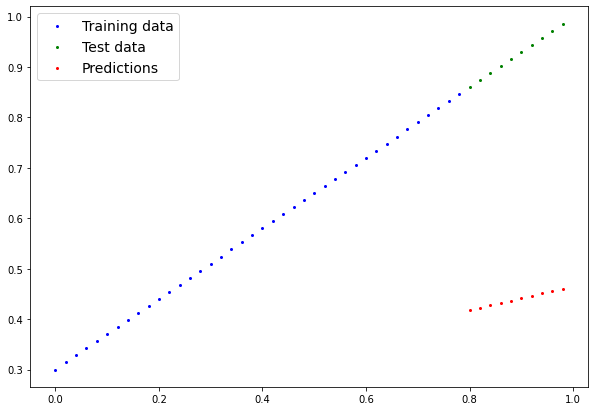

In [78]:
plt_predictions(predictions= y_preds_same_as_inference_mode)

### 3. Train the Model

The whole idea of training is for a model to move from some unnown parameters *these may be randoms) to some known parameters.

Or in other words froma poor representation of data to a better representation of the data.

One way to messure how poor  yoru model predictions are, is to use a loss function.
* Note : Los function may also be called cost fuciton or  criterrion in different areas. for our case, we are going to refer to refer it as loss function.

Things we need to train the model:

* **Loss Function:** A function to measure how wron your model's prediction are to the ideal outputs, lower is better.
* **Optimizer:** Takes into account the loss of the model and adjusts the model's parameters (e.g. weight and bias) to improve the function.

  inside the optimizer we need to set some parametrs:
  1. model parameter that we need to optimize (model_0, parameters())
  2. learning rate of the model


And specifically for PyTorch we need:
* a training loop
* a testing loop

In [79]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.2345], requires_grad=True), Parameter containing:
 tensor([0.2303], requires_grad=True)]

In [80]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.2345])), ('bias', tensor([0.2303]))])

In [81]:
# Set up a Loss function
loss_fn= nn.L1Loss()

# Set up an Optimizer (stochastic gradient descent)
optimizer= torch.optim.SGD(params= model_0.parameters(),
                           lr= 0.001) # learning rate= possibly the most important hyper parameter of the model


### Building a training Loop (and a testing loop) in PyTorch

A couple of things we need for a training loop:
0. Loop through the data
1. Forward pass (this involves data moving through our model's `forward()` funstions) to make predictions on data - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground trth labels)
3. Optimizer zero grad
4. Loss backward- move backwards through the network to calculate the gradient of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)


In [82]:
torch.manual_seed(42)
# An epoch is one loop through the data (this is a hyper parameter bc. we built it ourselves)
epochs= 2000

# Track different values for different models with different parameters
epoch_count= []
loss_values= []
test_loss_values= []

### training
# 0. Loop through the data
for epoch in range(epochs):
  
  # Set the model to trainig mode
  model_0. train() # train mode in pytorch sets all parameters that require gradients to require gradents
  
  # 1. Forward pass
  y_pred= model_0(X_train) # when we call the model actually it calls the forward method of the model
  
  # 2. Calculate the loss
  loss= loss_fn(y_pred, y_train)
  
  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. perform backpropagation on the loss with respect to model parameters
  loss.backward()

  # 5. Step the optimizer (perfrom gradient descent)
  optimizer.step() # by default how the optimizer changes will accumilate through the loop so... we have to zero them above in step 3 for the next iteration of the loop
  
  ### Testing the model
  model_0.eval() # turns off different settings in the model not needed for evaluation/testin (dropout /batch norm)
  with torch.inference_mode(): # turns off gradient tracking and a couple more things behind th scenes
  #with torch.no_grad() # you may also see torch.no_grad() in older pytorxh codes
    # 1. Do the forward pass
    test_pred= model_0(X_test)

    #2. calculate the loss
    test_loss = loss_fn(test_pred, y_test)
  if epoch % 100 ==0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    print(model_0.state_dict())



Epoch: 0 | Loss: 0.25122663378715515 | Test loss: 0.4826483726501465
OrderedDict([('weight', tensor([0.2349])), ('bias', tensor([0.2313]))])
Epoch: 100 | Loss: 0.14206227660179138 | Test loss: 0.35133546590805054
OrderedDict([('weight', tensor([0.2738])), ('bias', tensor([0.3280]))])
Epoch: 200 | Loss: 0.09158845990896225 | Test loss: 0.25953254103660583
OrderedDict([('weight', tensor([0.3097])), ('bias', tensor([0.3878]))])
Epoch: 300 | Loss: 0.07436230033636093 | Test loss: 0.20518529415130615
OrderedDict([('weight', tensor([0.3390])), ('bias', tensor([0.4161]))])
Epoch: 400 | Loss: 0.06764186918735504 | Test loss: 0.17438319325447083
OrderedDict([('weight', tensor([0.3626])), ('bias', tensor([0.4259]))])
Epoch: 500 | Loss: 0.06344695389270782 | Test loss: 0.15537860989570618
OrderedDict([('weight', tensor([0.3830])), ('bias', tensor([0.4268]))])
Epoch: 600 | Loss: 0.05994901806116104 | Test loss: 0.14429108798503876
OrderedDict([('weight', tensor([0.4010])), ('bias', tensor([0.4218]

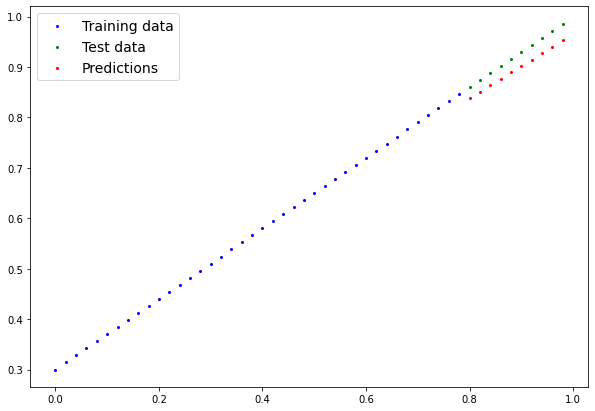

In [83]:
with torch.inference_mode():
  y_predictions_new= model_0(X_test)
  plt_predictions(X_train, y_train, X_test, y_test, predictions= y_predictions_new)

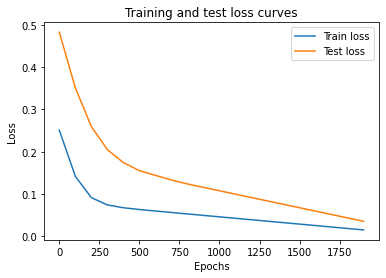

In [84]:
import numpy as np
# plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label= "Train loss")
plt.plot(epoch_count, np.array(torch.tensor(test_loss_values).numpy()), label= "Test loss")
plt.title("Training and test loss curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

### Saving the model in PyTorch
There are three main methods yu should know about for saving and loading models in PyTorch.
1. `torch.save()` - allows you save a PyTorch object in PyTorch's pickle format
2. `torch.load()` - allows yo to load a saved pytorch object
3. `torch.nn.Module.load_state_dict()` - allows to load a model's saved state dictionary.
 

In [85]:
# Saving our pytorch model
from pathlib import Path

# Create model's directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents= True, exist_ok=True)

# Create model's save path
MODEL_NAME= "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH= MODEL_PATH / MODEL_NAME
# Save the model's state_dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj= model_0.state_dict(),
           f= MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [86]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1063 Nov 26 08:15 01_pytorch_workflow_model_0.pth


## Loading a PyTorch model

Since we saved our model's `state_dict` rather than our entire model, we will creare a new instance if our model class and load the saved `state_dict()` into that.

In [87]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.6414])), ('bias', tensor([0.3246]))])

In [88]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0= LinearRegressionModel()

# Load the saved state_dict of model_0 (this will updata the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [89]:
loaded_model_0.state_dict()

OrderedDict([('weight', tensor([0.6414])), ('bias', tensor([0.3246]))])

In [90]:
# make some preds with our loaded model
loaded_model_0.eval()

with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)
loaded_model_preds

tensor([[0.8377],
        [0.8506],
        [0.8634],
        [0.8762],
        [0.8890],
        [0.9019],
        [0.9147],
        [0.9275],
        [0.9404],
        [0.9532]])

In [91]:
# make some model predictions
model_0.eval()
with torch.inference_mode():
  y_preds= model_0(X_test)
  

In [92]:
# compare loaded model preds with original preds
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together

Lets Go back through the steps above and see it all in one place

In [93]:
# import torch and matplot lib

import torch
from torch import nn
import matplotlib.pyplot as plt

# check the torch version
torch.__version__

'1.12.1+cu113'

## Create device agnostic code.
This means if we have got access to a GPU, our code will use to it (for potentially computing faster).
if no GPU is available, the code will default to using a CPU.


In [94]:
# Setup device agnostice code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


## 6.1 Data

In [95]:
# Create some data 

# Create weight and bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors will happen later on (shapes within linear layers)
y = weight * X + bias 


# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [97]:
# Subclass nn.Module to make our model
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1, 
                                      out_features=1)
    
    # Define the forward computation (input data x flows through nn.Linear())
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# Set the manual seed when creating the model (this isn't always need but is used for demonstrative purposes, try commenting it out and seeing what happens)
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

## Device Agnostic Code:

In [98]:
# Check model device
next(model_1.parameters()).device

# Set model to GPU if it's availalble, otherwise it'll default to CPU
model_1.to(device) # the device variable was set above to be "cuda" if available or "cpu" if not
next(model_1.parameters()).device

device(type='cpu')

## Training

In [99]:
# Create loss function
loss_fn = nn.L1Loss()

# Create optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), # optimize newly created model's parameters
                            lr=0.01)


In [100]:
# Subclass nn.Module to make our model
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1, 
                                      out_features=1)
    
    # Define the forward computation (input data x flows through nn.Linear())
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# Set the manual seed when creating the model (this isn't always need but is used for demonstrative purposes, try commenting it out and seeing what happens)
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()


(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [101]:
torch.manual_seed(42)

# Set the number of epochs 
epochs = 1000 

# Put data on the available device
# Without this, error will happen (not all model/data on device)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train() # train mode is on by default after construction

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model_1.eval() # put the model in evaluation mode for testing (inference)
    # 1. Forward pass
    with torch.inference_mode():
        test_pred = model_1(X_test)
    
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")


Epoch: 0 | Train loss: 0.5551779866218567 | Test loss: 0.5874472260475159
Epoch: 100 | Train loss: 0.5551779866218567 | Test loss: 0.5874472260475159
Epoch: 200 | Train loss: 0.5551779866218567 | Test loss: 0.5874472260475159
Epoch: 300 | Train loss: 0.5551779866218567 | Test loss: 0.5874472260475159
Epoch: 400 | Train loss: 0.5551779866218567 | Test loss: 0.5874472260475159
Epoch: 500 | Train loss: 0.5551779866218567 | Test loss: 0.5874472260475159
Epoch: 600 | Train loss: 0.5551779866218567 | Test loss: 0.5874472260475159
Epoch: 700 | Train loss: 0.5551779866218567 | Test loss: 0.5874472260475159
Epoch: 800 | Train loss: 0.5551779866218567 | Test loss: 0.5874472260475159
Epoch: 900 | Train loss: 0.5551779866218567 | Test loss: 0.5874472260475159


In [102]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[1.4416],
        [1.4569],
        [1.4722],
        [1.4875],
        [1.5028],
        [1.5181],
        [1.5334],
        [1.5487],
        [1.5640],
        [1.5793]])

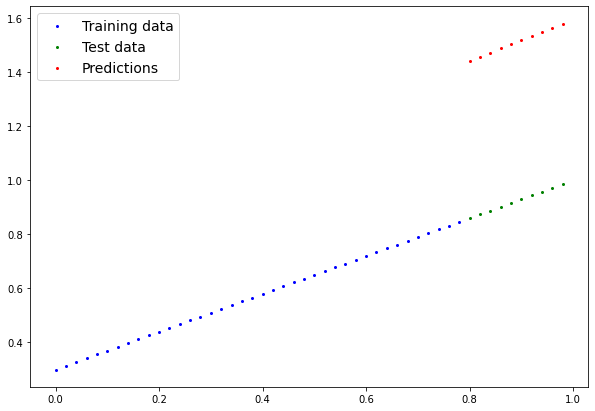

In [105]:
# plot_predictions(predictions=y_preds) # -> won't work... data not on CPU

# Put data on the CPU and plot it
plt_predictions(predictions=y_preds.cpu())

In [106]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth
